In [1]:
!pip install bs4
!pip install lxml
!pip install geopy
!pip install folium
!pip install uszipcode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
import json
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import requests
from scipy import stats
from sklearn.cluster import DBSCAN
from uszipcode import SearchEngine

Urls that contain datasets for zip codes, population, and legally operating businesses in NYC

In [2]:
url_zipcodes = 'https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm' # html for list of zip codes in nyc
url_population = 'https://www.newyork-demographics.com/zip_codes_by_population' # html for population by zip codes in nyc US census 2018
url_businesses = 'https://data.cityofnewyork.us/api/views/w7w3-xahh/rows.csv' # csv for legally operating businesses in nyc

Extract zip codes in nyc from url_zipcodes

In [3]:
html = urlopen(url_zipcodes)
soup = BeautifulSoup(html, 'lxml')
rows = soup.find_all("tr")
rows[0:5]

[<tr>
 <th abbr="Borough" id="header1">Borough</th>
 <th abbr="Neighborhood" id="header2">Neighborhood</th>
 <th abbr="ZIP Codes" id="header3">ZIP Codes</th>
 </tr>, <tr>
 <td headers="header1" rowspan="7">Bronx</td>
 <td headers="header2"> Central Bronx</td>
 <td headers="header3"> 10453, 10457, 10460</td>
 </tr>, <tr>
 <td headers="header2"> Bronx Park and Fordham</td>
 <td headers="header3"> 10458, 10467, 10468</td>
 </tr>, <tr>
 <td headers="header2"> High Bridge and Morrisania</td>
 <td headers="header3"> 10451, 10452, 10456</td>
 </tr>, <tr>
 <td headers="header2"> Hunts Point and Mott Haven</td>
 <td headers="header3"> 10454, 10455, 10459, 10474</td>
 </tr>]

In [4]:
data = []
i = 1
for i in range(len(rows)):
    row = []
    for r in rows[i].find_all("td"):
            row.append(r.string)
    data.append(row)
    i+=1
data[0:5]

[[],
 ['Bronx', ' Central Bronx', ' 10453, 10457, 10460'],
 [' Bronx Park and Fordham', ' 10458, 10467, 10468'],
 [' High Bridge and Morrisania', ' 10451, 10452, 10456'],
 [' Hunts Point and Mott Haven', ' 10454, 10455, 10459, 10474']]

In [5]:
data = data[19:29]
data[0].pop(0)
data

[[' Central Harlem', ' 10026, 10027, 10030, 10037, 10039'],
 [' Chelsea and Clinton', ' 10001, 10011, 10018, 10019, 10020, 10036'],
 [' East Harlem', ' 10029, 10035'],
 [' Gramercy Park and Murray Hill', ' 10010, 10016, 10017, 10022'],
 [' Greenwich Village and Soho', ' 10012, 10013, 10014'],
 [' Lower Manhattan', ' 10004, 10005, 10006, 10007, 10038, 10280'],
 [' Lower East Side', ' 10002, 10003, 10009'],
 [' Upper East Side', ' 10021, 10028, 10044, 10065, 10075, 10128'],
 [' Upper West Side', ' 10023, 10024, 10025'],
 [' Inwood and Washington Heights', ' 10031, 10032, 10033, 10034, 10040']]

In [6]:
for row in data:
    row.pop(0)
data

[[' 10026, 10027, 10030, 10037, 10039'],
 [' 10001, 10011, 10018, 10019, 10020, 10036'],
 [' 10029, 10035'],
 [' 10010, 10016, 10017, 10022'],
 [' 10012, 10013, 10014'],
 [' 10004, 10005, 10006, 10007, 10038, 10280'],
 [' 10002, 10003, 10009'],
 [' 10021, 10028, 10044, 10065, 10075, 10128'],
 [' 10023, 10024, 10025'],
 [' 10031, 10032, 10033, 10034, 10040']]

In [7]:
ndata = []
for row in data:
        ndata.append(str(row).strip('[\'\']').split(','))
ndata

[[' 10026', ' 10027', ' 10030', ' 10037', ' 10039'],
 [' 10001', ' 10011', ' 10018', ' 10019', ' 10020', ' 10036'],
 [' 10029', ' 10035'],
 [' 10010', ' 10016', ' 10017', ' 10022'],
 [' 10012', ' 10013', ' 10014'],
 [' 10004', ' 10005', ' 10006', ' 10007', ' 10038', ' 10280'],
 [' 10002', ' 10003', ' 10009'],
 [' 10021', ' 10028', ' 10044', ' 10065', ' 10075', ' 10128'],
 [' 10023', ' 10024', ' 10025'],
 [' 10031', ' 10032', ' 10033', ' 10034', ' 10040']]

In [8]:
zipcodes = []
for row in ndata:
    for zc in row:
        zipcodes.append(zc.strip(' '))
zipcodes

['10026',
 '10027',
 '10030',
 '10037',
 '10039',
 '10001',
 '10011',
 '10018',
 '10019',
 '10020',
 '10036',
 '10029',
 '10035',
 '10010',
 '10016',
 '10017',
 '10022',
 '10012',
 '10013',
 '10014',
 '10004',
 '10005',
 '10006',
 '10007',
 '10038',
 '10280',
 '10002',
 '10003',
 '10009',
 '10021',
 '10028',
 '10044',
 '10065',
 '10075',
 '10128',
 '10023',
 '10024',
 '10025',
 '10031',
 '10032',
 '10033',
 '10034',
 '10040']

A list that contains zip codes in nyc is now created

In [9]:
len(zipcodes)

43

Now extract population per zip code from url_population

In [10]:
html = urlopen(url_population)
soup = BeautifulSoup(html, 'lxml')
rows = soup.find_all("tr")
rows[0:5]

[<tr>
 <th>Rank</th>
 <th>Zip Code</th>
 <th>Population</th>
 </tr>, <tr>
 <td>
         1
       </td>
 <td>
 <a href="11368-demographics">11368</a>
 </td>
 <td>
         112,425
 
       </td>
 </tr>, <tr>
 <td>
         2
       </td>
 <td>
 <a href="11385-demographics">11385</a>
 </td>
 <td>
         106,717
 
       </td>
 </tr>, <tr>
 <td>
         3
       </td>
 <td>
 <a href="10467-demographics">10467</a>
 </td>
 <td>
         103,732
 
       </td>
 </tr>, <tr>
 <td>
         4
       </td>
 <td>
 <a href="11211-demographics">11211</a>
 </td>
 <td>
         102,624
 
       </td>
 </tr>]

In [11]:
col = []
for r in rows[0].find_all("th"):
    col.append(r.string.strip('\n'))
col

['Rank', 'Zip Code', 'Population']

In [12]:
data = []
i = 1
for i in range(len(rows)):
    row = []
    for r in rows[i].find_all("td"):
            row.append(r.get_text().strip())
    data.append(row)
    i+=1
data[0:5]

[[],
 ['1', '11368', '112,425'],
 ['2', '11385', '106,717'],
 ['3', '10467', '103,732'],
 ['4', '11211', '102,624']]

In [13]:
ndata = []
for row in data:
    for item in row:
        if (item in zipcodes):
            ndata.append(row)
print(len(ndata))
ndata[0:5]

42


[['13', '10025', '92,805'],
 ['26', '10029', '79,597'],
 ['35', '10002', '74,993'],
 ['52', '10027', '64,548'],
 ['54', '10032', '64,264']]

In [14]:
df_population = pd.DataFrame(ndata, columns = col)
print(df_population.shape)
df_population.head()

(42, 3)


,Rank,Zip Code,Population
0,13,10025,"92,805"
1,26,10029,"79,597"
2,35,10002,"74,993"
3,52,10027,"64,548"
4,54,10032,"64,264"


In [15]:
df_population = df_population.drop(columns = 'Rank')
df_population.head()

,Zip Code,Population
0,10025,"92,805"
1,10029,"79,597"
2,10002,"74,993"
3,10027,"64,548"
4,10032,"64,264"


In [16]:
df_population.sort_values(by=['Zip Code'], ascending=True, inplace=True)
df_population.reset_index(inplace=True)
df_population.drop(columns=['index'], inplace=True)
print(df_population.shape)
df_population.head()

(42, 2)


,Zip Code,Population
0,10001,"22,924"
1,10002,"74,993"
2,10003,"54,682"
3,10004,"3,028"
4,10005,"8,831"


A _dataframe_ containing population per zip code is created

Now extract numbers of businesses per zip code from url_business

In [17]:
df = pd.read_csv(url_businesses)
df.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,DCA License Number,License Type,License Expiration Date,License Status,License Creation Date,Industry,Business Name,Business Name 2,Address Building,Address Street Name,...,Community Board,Council District,BIN,BBL,NTA,Census Tract,Detail,Longitude,Latitude,Location
0,2080385-DCA,Individual,10/31/2020,Active,12/03/2018,Tow Truck Driver,"DELACRUZ VARGAS, CARLOS",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2032192-DCA,Individual,02/28/2021,Active,01/06/2016,Home Improvement Salesperson,"ALEXANDER, JAROSLAV",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1124491-DCA,Business,06/30/2009,Inactive,10/01/2002,Home Improvement Contractor,"BETCON, INC.",NaN,2,PLANK RD,...,502.0,50.0,5036968,5022320090,SI05,29103.0,NaN,-74.166658,40.609257,"(40.609256590908565, -74.16665821883805)"
3,2064922-DCA,Individual,02/28/2021,Active,01/12/2018,Home Improvement Salesperson,"AHMETAJ, ARANIT",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1356487-DCA,Individual,02/28/2021,Active,05/27/2010,Home Improvement Salesperson,"SATTER, NEAL L",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df.shape

(265821, 27)

Filter only businesses in New York, NY (Borough Code 1) and with active license status

In [19]:
df = df.loc[(df['Borough Code'] == 1) & (df['License Status'] == 'Active')]
df.shape

(9161, 27)

In [20]:
df.rename(columns={'Address ZIP':'Zip Code','DCA License Number':'Legally Operating Businesses'}, inplace=True)
df = df.groupby(['Zip Code']).count().filter(['Zip Code','Legally Operating Businesses'])
df.head()

,Legally Operating Businesses
Zip Code,
000,1
07086,1
10001,433
10002,347
10003,407


In [21]:
df_businesses = pd.DataFrame(columns = ['Legally Operating Businesses'])
df_businesses.index.name = 'Zip Code'
for zc in zipcodes:
    if (zc in df.index.tolist()):
        df_businesses = df_businesses.append(df.loc[zc])
df_businesses.sort_index(ascending=True, inplace=True)
df_businesses.reset_index(inplace=True)
print(df_businesses.shape)
df_businesses.head()

(43, 2)


,Zip Code,Legally Operating Businesses
0,10001,433
1,10002,347
2,10003,407
3,10004,80
4,10005,62


To a new dataframe df, append columns containing zip codes, population, and number of legally operating businesses per zip codes

In [22]:
df = df_population.copy()
df['Legally Operating Businesses'] = df_businesses['Legally Operating Businesses']
print(df.shape)
df.head()

(42, 3)


,Zip Code,Population,Legally Operating Businesses
0,10001,"22,924",433
1,10002,"74,993",347
2,10003,"54,682",407
3,10004,"3,028",80
4,10005,"8,831",62


Get the numbers of coffee shops per zip codes from the Foursquare API

In [23]:
# The code was removed by Watson Studio for sharing.

CLIENT_ID, CLIENT_SECRET, and VERSION defined!


In [24]:
# function that gets category types of venues
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

List of neighborhoods in Manhattan whose coordinates will be used to get the venue information through the Foursquare API

In [25]:
manhattan = ['Battery Park City', 'Financial District', 'Tribeca, Chinatown', 
             'Greenwich Village', 'Little Italy', 'Lower East Side', 'NoHo', 'SoHo', 
             'West Village', 'Alphabet City', 'Chinatown', 'East Village', 'Lower East Side', 
             'Two Bridges', 'Chelsea', 'Clinton', 'Hell\'s Kitchen', 'Hudson Yards', 'Midtown', 
             'Gramercy Park', 'Kips Bay', 'Rose Hill', 'Murray Hill', 'Peter Cooper Village', 
             'Stuyvesant Town', 'Sutton Place', 'Tudor City', 'Turtle Bay', 'Waterside Plaza', 
             'Lincoln Square', 'Manhattan Valley', 'Upper West Side', 'Lenox Hill', 
             'Roosevelt Island', 'Upper East Side', 'Yorkville', 'Hamilton Heights', 
             'Manhattanville', 'Morningside Heights', 'Harlem', 'Polo Grounds', 
             'East Harlem', 'Randall\'s Island', 'Spanish Harlem', 'Wards Island', 'Inwood', 'Washington Heights']

In [26]:
coordinates = []
geolocator = Nominatim(user_agent="nyc_explorer")
for neighborhood in manhattan:
    address = neighborhood + ', NY'
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    latlon = [latitude, longitude]
    coordinates.append(latlon)

In [27]:
coordinates

[[40.7110166, -74.0169369],
 [40.7076124, -74.009378],
 [40.7183969, -74.0041959],
 [40.7335844, -74.0028172],
 [40.7192728, -73.9982152],
 [40.7159357, -73.9868057],
 [40.7258746, -73.9939566],
 [40.72288, -73.9987505],
 [40.7341857, -74.00558],
 [40.7251022, -73.9795833],
 [40.7164913, -73.9962504],
 [40.7292688, -73.9873613],
 [40.7159357, -73.9868057],
 [40.7112884, -73.9922333],
 [40.7464906, -74.0015283],
 [43.0484029, -75.3785034],
 [40.7644228, -73.9923918],
 [40.7559064, -74.0005322],
 [40.7601085, -73.97816329087175],
 [40.73792525, -73.98593239621584],
 [40.7395463, -73.9770832],
 [40.743338, -73.9841594],
 [40.76, -73.8130556],
 [40.73391845, -73.97603006210491],
 [40.731971099999996, -73.97809278130401],
 [40.68058, -73.635843],
 [40.7486231, -73.9713889],
 [40.7534666, -73.9688659],
 [40.737580550000004, -73.97324218457551],
 [40.7723194, -73.9844012],
 [40.7997764, -73.9677716],
 [40.7870455, -73.9754163],
 [40.7664366, -73.9590168],
 [40.7614177, -73.9502281671115],
 [4

Make Foursquare calls (by the category id's for Coffee Shop and Café) for each neighborhood, drop duplicate, and save to dataframe

In [28]:
coffee = pd.DataFrame()
LIMIT = 50
i = 0
radius = 1000
for loc in range(len(coordinates)):
    latitude = coordinates[i][0]
    longitude = coordinates[i][1]
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId=4bf58dd8d48988d16d941735,4bf58dd8d48988d1e0931735&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    results = requests.get(url).json()
    venues = results['response']['venues']
    dataframe = json_normalize(venues)
    coffee = coffee.append(dataframe)
    i+=1
coffee.drop_duplicates(subset='id', inplace=True)
print(coffee.shape)
coffee.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(918, 25)


,categories,delivery.id,delivery.provider.icon.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.name,delivery.url,hasPerk,id,location.address,...,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",NaN,NaN,NaN,NaN,NaN,NaN,False,538df67d498e8697475982ee,225 Liberty St,...,"[225 Liberty St, New York, NY 10281, United St...","[{'label': 'display', 'lat': 40.71319964431583...",40.713200,-74.015857,NaN,10281,NY,Olive's,v-1596107850,NaN
1,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",NaN,NaN,NaN,NaN,NaN,NaN,False,49ccd495f964a52091591fe3,275 Greenwich St,...,"[275 Greenwich St (at Murray St), New York, NY...","[{'label': 'display', 'lat': 40.71504512558996...",40.715045,-74.011509,NaN,10007,NY,Kaffe 1668,v-1596107850,43231093
2,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",NaN,NaN,NaN,NaN,NaN,NaN,False,59bd506ce2d4aa3d68b99a88,150 Greenwich St,...,"[150 Greenwich St (Liberty), New York, NY 1000...","[{'label': 'display', 'lat': 40.7105890125794,...",40.710589,-74.012371,Financial District,10007,NY,Blue Bottle Coffee,v-1596107850,NaN
3,"[{'id': '4bf58dd8d48988d112941735', 'name': 'J...",1536101,/delivery_provider_seamless_20180129.png,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",seamless,https://www.seamless.com/menu/joe--the-juice-b...,False,5a705f36c62b49492c99942f,40 Broad Street,...,"[40 Broad Street, New York, NY 10004, United S...","[{'label': 'display', 'lat': 40.70594106612217...",40.705941,-74.011644,NaN,10004,NY,JOE & THE JUICE,v-1596107850,NaN
4,"[{'id': '4bf58dd8d48988d148941735', 'name': 'D...",1095602,/delivery_provider_seamless_20180129.png,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",seamless,https://www.seamless.com/menu/dunkin-80-john-s...,False,5708174c498e2f86efd38834,80 John St,...,"[80 John St (Gold St), New York, NY 10038, Uni...","[{'label': 'display', 'lat': 40.70826381727740...",40.708264,-74.006827,Financial District,10038,NY,Dunkin',v-1596107850,NaN


Keep only columns that include venue name and anything about location, filter the category for each row, clean column names by keeping only last term

In [29]:
filtered_columns = ['name', 'categories'] + [col for col in coffee.columns if col.startswith('location.')] + ['id']
coffee_filtered = coffee.loc[:, filtered_columns]

coffee_filtered['categories'] = coffee_filtered.apply(get_category_type, axis=1)

coffee_filtered.columns = [column.split('.')[-1] for column in coffee_filtered.columns]

print(coffee_filtered.shape)
coffee_filtered.head()

(918, 16)


,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Olive's,Sandwich Place,225 Liberty St,US,New York,United States,NaN,259,"[225 Liberty St, New York, NY 10281, United St...","[{'label': 'display', 'lat': 40.71319964431583...",40.713200,-74.015857,NaN,10281,NY,538df67d498e8697475982ee
1,Kaffe 1668,Coffee Shop,275 Greenwich St,US,New York,United States,at Murray St,641,"[275 Greenwich St (at Murray St), New York, NY...","[{'label': 'display', 'lat': 40.71504512558996...",40.715045,-74.011509,NaN,10007,NY,49ccd495f964a52091591fe3
2,Blue Bottle Coffee,Coffee Shop,150 Greenwich St,US,New York,United States,Liberty,388,"[150 Greenwich St (Liberty), New York, NY 1000...","[{'label': 'display', 'lat': 40.7105890125794,...",40.710589,-74.012371,Financial District,10007,NY,59bd506ce2d4aa3d68b99a88
3,JOE & THE JUICE,Juice Bar,40 Broad Street,US,New York,United States,NaN,720,"[40 Broad Street, New York, NY 10004, United S...","[{'label': 'display', 'lat': 40.70594106612217...",40.705941,-74.011644,NaN,10004,NY,5a705f36c62b49492c99942f
4,Dunkin',Donut Shop,80 John St,US,New York,United States,Gold St,906,"[80 John St (Gold St), New York, NY 10038, Uni...","[{'label': 'display', 'lat': 40.70826381727740...",40.708264,-74.006827,Financial District,10038,NY,5708174c498e2f86efd38834


As you can see in the category types of venues, similar places such as donut shop, bakery, tea room, dessert shop etc. where you can also get coffee are included in the research

In [30]:
coffee_filtered.rename(columns={'postalCode':'Zip Code'}, inplace=True)
dataframe = coffee_filtered.groupby('Zip Code').count().filter(['id'])
df_coffee = pd.DataFrame(columns = ['id'])
df_coffee.index.name = 'Zip Code'
for zc in zipcodes:
    if (zc in dataframe.index.tolist()):
        df_coffee = df_coffee.append(dataframe.loc[zc])
df_coffee.sort_index(ascending=True, inplace=True)
df_coffee.reset_index(inplace=True)
df_coffee.rename(columns={'id':'Coffee Shops'}, inplace=True)
print(df_coffee.shape)
df_coffee.head()

(43, 2)


,Zip Code,Coffee Shops
0,10001,24
1,10002,25
2,10003,41
3,10004,10
4,10005,9


Now a new column containing the numbers of coffee shops per zip codes is added to the dataframe df

In [31]:
df['Coffee Shops'] = df_coffee['Coffee Shops']
print(df.shape)
df.head()

(42, 4)


,Zip Code,Population,Legally Operating Businesses,Coffee Shops
0,10001,"22,924",433,24
1,10002,"74,993",347,25
2,10003,"54,682",407,41
3,10004,"3,028",80,10
4,10005,"8,831",62,9


In [32]:
df.dtypes

Zip Code                        object
Population                      object
Legally Operating Businesses    object
Coffee Shops                    object
dtype: object

Change data types of Population, Legally Operating Businesses, and Coffee Shops to int

In [33]:
df['Population'] = df['Population'].str.replace(',','').astype(int)
df['Legally Operating Businesses'] = df['Legally Operating Businesses'].astype(int)
df['Coffee Shops'] = df['Coffee Shops'].astype(int)
df.dtypes

Zip Code                        object
Population                       int64
Legally Operating Businesses     int64
Coffee Shops                     int64
dtype: object

Correlation between population density and the number of coffee shops

In [34]:
df.corr()

,Population,Legally Operating Businesses,Coffee Shops
Population,1.000000,0.174212,0.272490
Legally Operating Businesses,0.174212,1.000000,0.763057
Coffee Shops,0.272490,0.763057,1.000000


In [35]:
pearson_coef, p_value = stats.pearsonr(df['Population'], df['Coffee Shops'])
print("Pearson correlation coefficient between population density and the number of coffee shops: ", pearson_coef, "\nP-value:", p_value) 

Pearson correlation coefficient between population density and the number of coffee shops:  0.2724900598524973 
P-value: 0.0808369146467996


In [36]:
pearson_coef, p_value = stats.pearsonr(df['Legally Operating Businesses'], df['Coffee Shops'])
print("Pearson correlation coefficient between the number of legally operaing businesses and the number of coffee shops: ", pearson_coef, "\nP-value:", p_value) 

Pearson correlation coefficient between the number of legally operaing businesses and the number of coffee shops:  0.7630573736804499 
P-value: 4.2334243415566434e-09


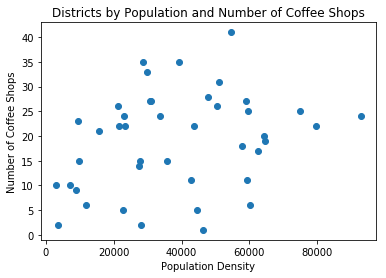

In [66]:
plt.scatter('Population', 'Coffee Shops', data=df)
plt.title('Districts by Population and Number of Coffee Shops')
plt.xlabel('Population Density')
plt.ylabel('Number of Coffee Shops')
plt.show()

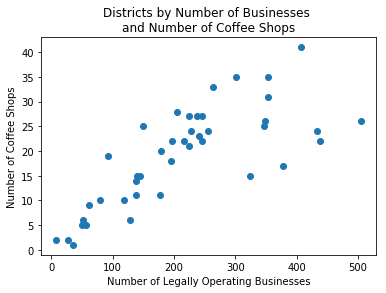

In [65]:
plt.scatter('Legally Operating Businesses', 'Coffee Shops', data=df)
plt.title('Districts by Number of Businesses \nand Number of Coffee Shops')
plt.xlabel('Number of Legally Operating Businesses')
plt.ylabel('Number of Coffee Shops')
plt.show()

Text(0.5, 1.0, 'Districts by Population \nand Number of Coffee Shops')

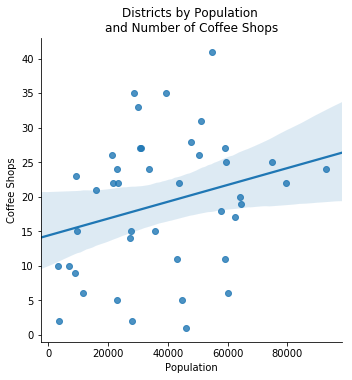

In [71]:
sns.lmplot(x='Population', y='Coffee Shops', data=df)
ax = plt.gca()
ax.set_title("Districts by Population \nand Number of Coffee Shops")

As you can see by the correlation coefficient and scatter plot, there is not a significant correlation between population density and the number of coffee shops meaning that opening a coffee shop where highly populated might not necessarily mean high profit

Text(0.5, 1.0, 'Districts by Number of Businesses \nand Number of Coffee Shops')

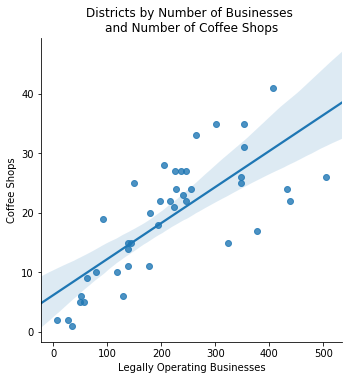

In [70]:
sns.lmplot(x='Legally Operating Businesses', y='Coffee Shops', data=df)
ax = plt.gca()
ax.set_title("Districts by Number of Businesses \nand Number of Coffee Shops")

As you can see by the correlation coefficient and scatter plot, there is a positive correlation between the number of businesses and the number of coffee shops which means that you are likely to succeed if you open a coffee shop in regions with a high number of businesses and a small number of coffee shops

Use DBSCAN to detect outliers on the scatter plot of districts by the number of businesses and coffee shops

In [41]:
dbscan = DBSCAN(eps = 24, min_samples = 4)
model = dbscan.fit(df[['Legally Operating Businesses','Coffee Shops']])
print(model.labels_)

[-1  0 -1  1  1  1  2  3  3  0  3  0  3  0  3 -1 -1  1  3 -1  3  3 -1  1
  3  3  3  1  3  2  3  2  2 -1  1  2  1  2  1  3  2  3]


In [42]:
labels = model.labels_
labels

array([-1,  0, -1,  1,  1,  1,  2,  3,  3,  0,  3,  0,  3,  0,  3, -1, -1,
        1,  3, -1,  3,  3, -1,  1,  3,  3,  3,  1,  3,  2,  3,  2,  2, -1,
        1,  2,  1,  2,  1,  3,  2,  3])

Perform Density Based Clustering (DBSCAN) on scatter plot of districts by the number of businesses and the number of coffee shops to discover outliers that diverge from the cluster body, that have fewer coffee shops in the area for their number of businesses

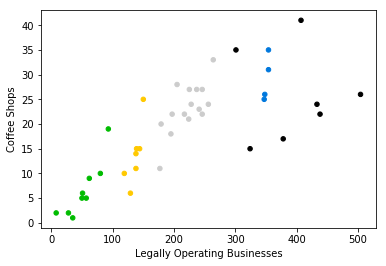

In [43]:
cmap = cm.get_cmap('nipy_spectral')
df.plot.scatter(
  x = 'Legally Operating Businesses',
  y = 'Coffee Shops',
  c = model.labels_,
  cmap = cmap,
  colorbar = False
)

You see 7 outliers in BLACK that are located far from the main cluster body(in colors), and among them are 5 BLACK outliers that lie under the cluster body on the lower right of the graph, which represent the districts that have fewer number of coffee shops for the number of businesses in those districts

In [44]:
df['Cluster Labels'] = model.labels_
df.head()

,Zip Code,Population,Legally Operating Businesses,Coffee Shops,Cluster Labels
0,10001,22924,433,24,-1
1,10002,74993,347,25,0
2,10003,54682,407,41,-1
3,10004,3028,80,10,1
4,10005,8831,62,9,1


Rows with Cluster Labels of -1 are the outliers

In [45]:
df.loc[df['Cluster Labels'] == -1]

,Zip Code,Population,Legally Operating Businesses,Coffee Shops,Cluster Labels
0,10001,22924,433,24,-1
2,10003,54682,407,41,-1
15,10018,9687,324,15,-1
16,10019,43703,438,22,-1
19,10023,62435,378,17,-1
22,10026,39363,301,35,-1
33,10037,21139,504,26,-1


Change the Cluster Labels of the 2 outliers that are located above the cluster body, which means they have sufficient numbers of coffee shops for the number of businesses so they would not be good target districts to open a coffee shop

In [46]:
# change cluster labels for the 2 areas that are outliers but have over 30 coffee shops
df.loc[(df['Cluster Labels'] == -1) & (df['Coffee Shops'] > 30), 'Cluster Labels'] = 0

Now we have the 5 target districts with fewer coffee shops in proportion to businesses, all with Cluster Label of -1, which would be the solution to the problem 

In [47]:
df.loc[df['Cluster Labels'] == -1]

,Zip Code,Population,Legally Operating Businesses,Coffee Shops,Cluster Labels
0,10001,22924,433,24,-1
15,10018,9687,324,15,-1
16,10019,43703,438,22,-1
19,10023,62435,378,17,-1
33,10037,21139,504,26,-1


Using the _uszipcode_ library, get latitudes and longitudes for each zip code district

In [48]:
# test
search = SearchEngine(simple_zipcode=True)
zipcode = search.by_zipcode("10001")
lookup = zipcode.values()
lookup[7:9]

[40.75, -73.99]

In [49]:
search = SearchEngine(simple_zipcode=True)

latitude = []
longitude = []

for zc in df['Zip Code']:
    zipcode = search.by_zipcode(zc)
    lookup = zipcode.values()
    latitude.append(lookup[7])
    longitude.append(lookup[8])
    
df['Latitude'] = latitude
df['Longitude'] = longitude
df.head()

,Zip Code,Population,Legally Operating Businesses,Coffee Shops,Cluster Labels,Latitude,Longitude
0,10001,22924,433,24,-1,40.750,-73.990
1,10002,74993,347,25,0,40.720,-73.990
2,10003,54682,407,41,0,40.730,-73.990
3,10004,3028,80,10,1,40.700,-74.020
4,10005,8831,62,9,1,40.705,-74.005


Now the df dataframe has 2 new rows - latitude and longitude of the zip code areas

Change Cluster Labels:
* Districts in the cluster body (not targets, Cluster Label not equal to -1) to 0
* Districts that are the outliers (targets and also outliers, Cluster Label equal to -1) to 1

In [50]:
df.loc[df['Cluster Labels'] != -1 ,'Cluster Labels'] = 0
df.loc[df['Cluster Labels'] == -1 ,'Cluster Labels'] = 1

Make 2 new dataframes:
* df_others containing rows of districts that are not the target (Cluster Label 0)
* df_solution containing rows of districts that are the target/solutions with fewer coffee shops in proportion to the number of businesses (Cluster Label 1)

In [51]:
df_others = df.loc[df['Cluster Labels'] == 0]
df_solution = df.loc[df['Cluster Labels'] == 1]

In [52]:
print(df_others.shape)
df_others.head()

(37, 7)


,Zip Code,Population,Legally Operating Businesses,Coffee Shops,Cluster Labels,Latitude,Longitude
1,10002,74993,347,25,0,40.720,-73.990
2,10003,54682,407,41,0,40.730,-73.990
3,10004,3028,80,10,0,40.700,-74.020
4,10005,8831,62,9,0,40.705,-74.005
5,10006,3454,28,2,0,40.708,-74.013


In [53]:
print(df_solution.shape)
df_solution.head()

(5, 7)


,Zip Code,Population,Legally Operating Businesses,Coffee Shops,Cluster Labels,Latitude,Longitude
0,10001,22924,433,24,1,40.750,-73.990
15,10018,9687,324,15,1,40.760,-73.990
16,10019,43703,438,22,1,40.770,-73.990
19,10023,62435,378,17,1,40.780,-73.980
33,10037,21139,504,26,1,40.814,-73.937


In [54]:
# update to more accurate coordiantes for zip codes
df_solution.loc[df_solution['Zip Code'] == '10018', 'Latitude'] = 40.758
df_solution.loc[df_solution['Zip Code'] == '10018', 'Longitude'] = -73.999
df_solution.loc[df_solution['Zip Code'] == '10019', 'Latitude'] = 40.767
df_solution.loc[df_solution['Zip Code'] == '10019', 'Longitude'] = -73.989
df_solution.loc[df_solution['Zip Code'] == '10023', 'Latitude'] = 40.776
df_solution.loc[df_solution['Zip Code'] == '10023', 'Longitude'] = -73.983
df_solution.loc[df_solution['Zip Code'] == '10001', 'Latitude'] = 40.750
df_solution.loc[df_solution['Zip Code'] == '10001', 'Longitude'] = -73.995

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [55]:
# update to more accurate coordinates for zip codes
df_others.loc[df_others['Zip Code'] == '10024', 'Latitude'] = 40.786
df_others.loc[df_others['Zip Code'] == '10024', 'Longitude'] = -73.975
df_others.loc[df_others['Zip Code'] == '10016', 'Latitude'] = 40.745
df_others.loc[df_others['Zip Code'] == '10016', 'Longitude'] = -73.978
df_others.loc[df_others['Zip Code'] == '10004', 'Latitude'] = 40.703
df_others.loc[df_others['Zip Code'] == '10004', 'Longitude'] = -74.012
df_others.loc[df_others['Zip Code'] == '10280', 'Latitude'] = 40.709
df_others.loc[df_others['Zip Code'] == '10280', 'Longitude'] = -74.016
df_others.loc[df_others['Zip Code'] == '10005', 'Latitude'] = 40.706
df_others.loc[df_others['Zip Code'] == '10005', 'Longitude'] = -74.008
df_others.loc[df_others['Zip Code'] == '10014', 'Latitude'] = 40.736
df_others.loc[df_others['Zip Code'] == '10014', 'Longitude'] = -74.006
df_others.loc[df_others['Zip Code'] == '10016', 'Latitude'] = 40.745
df_others.loc[df_others['Zip Code'] == '10016', 'Longitude'] = -73.979
df_others.loc[df_others['Zip Code'] == '10044', 'Latitude'] = 40.761
df_others.loc[df_others['Zip Code'] == '10044', 'Longitude'] = -73.950
df_others.loc[df_others['Zip Code'] == '10039', 'Latitude'] = 40.827
df_others.loc[df_others['Zip Code'] == '10039', 'Longitude'] = -73.938
df_others.loc[df_others['Zip Code'] == '10027', 'Latitude'] = 40.814
df_others.loc[df_others['Zip Code'] == '10027', 'Longitude'] = -73.951
df_others.loc[df_others['Zip Code'] == '10033', 'Latitude'] = 40.850
df_others.loc[df_others['Zip Code'] == '10033', 'Longitude'] = -73.934
df_others.loc[df_others['Zip Code'] == '10034', 'Latitude'] = 40.871
df_others.loc[df_others['Zip Code'] == '10034', 'Longitude'] = -73.920
df_others.loc[df_others['Zip Code'] == '10017', 'Latitude'] = 40.753
df_others.loc[df_others['Zip Code'] == '10017', 'Longitude'] = -73.974
df_others.loc[df_others['Zip Code'] == '10075', 'Latitude'] = 40.774
df_others.loc[df_others['Zip Code'] == '10075', 'Longitude'] = -73.958
df_others.loc[df_others['Zip Code'] == '10028', 'Latitude'] = 40.775
df_others.loc[df_others['Zip Code'] == '10028', 'Longitude'] = -73.951
df_others.loc[df_others['Zip Code'] == '10002', 'Latitude'] = 40.714
df_others.loc[df_others['Zip Code'] == '10002', 'Longitude'] = -73.985
df_others.loc[df_others['Zip Code'] == '10031', 'Latitude'] = 40.826
df_others.loc[df_others['Zip Code'] == '10031', 'Longitude'] = -73.949
df_others.loc[df_others['Zip Code'] == '10029', 'Latitude'] = 40.792
df_others.loc[df_others['Zip Code'] == '10029', 'Longitude'] = -73.941
df_others.loc[df_others['Zip Code'] == '10010', 'Latitude'] = 40.738
df_others.loc[df_others['Zip Code'] == '10010', 'Longitude'] = -73.981

Central Park is located at the center of New York, NY, which will be used to create a choropleth map on

In [56]:
address = 'Central Park, NY'

geolocator = Nominatim(user_agent="nyc_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
nyc = [latitude, longitude]
print('Coordinate of {}: {}'.format(address, nyc))

Coordinate of Central Park, NY: [40.7827725, -73.9653627406542]


Check if the JSON file is valid, then download it and assign it to nyc_geo

In [57]:
url = 'https://github.com/ynylgm/Final-Project-for-Applied-Data-Science-Capstone/blob/master/nyc.json?raw=true'
r = requests.get(url)
try:
    data = r.json()
except ValueError:
    print("Response content is not valid JSON")

In [58]:
!wget --quiet https://github.com/ynylgm/Final-Project-for-Applied-Data-Science-Capstone/blob/master/nyc.json?raw=true -O nyc.json
    
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [59]:
nyc_geo = r'nyc.json'

nyc_map = folium.Map(location=[latitude, longitude], zoom_start=12)

Now create a _folium_ choropleth map that illustrates:
* Map with zip code boundaries of New York, NY from the GeoJSON file
* Representation of the number of businesses: the stronger the color is, the more businesses legally operates in that zip code district
* 2 types of distingushed markers for the target/solution districts and other districts
* Pop-ups on markers when clicked, that read the zip code and the number of coffee shops

In [60]:
threshold_scale = np.linspace(0,
                              df['Legally Operating Businesses'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() 
threshold_scale[-1] = threshold_scale[-1] + 1 

nyc_map.choropleth(
    geo_data=nyc_geo,
    data=df,
    columns=['Zip Code', 'Legally Operating Businesses'],
    key_on='feature.properties.zcta',
    threshold_scale=threshold_scale,
    fill_color='Blues', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Number of Legally Operating Businesses'
)

for lat, lon, zc, cs in zip(df_others['Latitude'], df_others['Longitude'], df_others['Zip Code'], df_others['Coffee Shops']):
    label = folium.Popup(str(zc) + ' Coffee Shops ' + str(cs), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color='#808080',
        opacity=0.3,
        fill=True,
        fill_color='#808080',
        fill_opacity=0.7).add_to(nyc_map)
    
for lat, lon, zc, cs in zip(df_solution['Latitude'], df_solution['Longitude'], df_solution['Zip Code'], df_solution['Coffee Shops']):
    label = folium.Popup(str(zc) + ' Coffee Shops ' + str(cs), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=11,
        popup=label,
        color='#FF4F4F',
        opacity=0.3,
        fill=True,
        fill_color='#FF4F4F',
        fill_opacity=0.85).add_to(nyc_map)

nyc_map

/opt/conda/envs/Python36/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


When you click on the markers, zip codes and the number of coffee shops pop up. <br>
The stronger the color is, the more businesses legally operate in that zip code district. <br>
There are __5 strongly-colored districts with bigger red marks__. <br>
They represent the districts with higher number of businesses and lower number of coffee shops and they are equivalent to the __solution__ of this project.
If you are looking to open a coffee shop in New York, NY, you would want to consider these districts as they, according to my research, have a satisfactory number of operating businesses and a few number of coffee shops, which means that they have sufficient numbers of potential customers and not many competitors in the café business. <br>
__The solution/target zip code districts with more potential customers and less competitors are: 10001, 10018, 10019, 10023, 10037.__